<a href="https://colab.research.google.com/github/RafalCer/Machine_learning/blob/main/ML_models_for_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INTRODUCTION**

This notebook presents an exploration of a try-out of a few probabilistic and non-probabilistic Machine Learning models in NLP. The models were tested on two data sets, namely Newsgroups and Reuters, both of which contain mostly news articles. 

The sections of the notebook are as follows:


1.   Data processing/parsing
2.   Feature extraction
2.   Model and hyperparameters choice
2.   Evaluation of the models

The notebook was submitted for an assignment during the Machine Learning for Language Technology course at Uppsala University. 







# **DATA PARSING**
1) **Newsgroups** - Pre-processed data is imported directly from scikit-learn.

To minimize the inductive bias, the headers, footers, and quotes are removed. This is done because, according to the documentation, numerous tokens in these sections restrict models' generalisation. In other words, the model would not be able to adequately categorise unseen data, as quotes more common in one some categories over the other and so on.



2) **Reuters** - The data is manually parsed with RegEx. 

The data is parsed in a way that only extracts two elements, namely TOPICS (corresponding to the category) and BODY. I decided not to include the titles and metadata since these pieces of information could affect the model's ability to generalise.

In [ ]:
############################### NEWSGROUPS #####################################
from sklearn.datasets import fetch_20newsgroups

newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes')) # used for parameter search using cross validation 
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

################################# REUTERS ######################################
import tarfile
import os
import re
import numpy as np

!wget -N https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.tar.gz

def extract_reuters(skip_empty_bodies=True, skip_empty_topics=True, skip_1_hit_topics=True):
  tar = tarfile.open('reuters21578.tar.gz')
  tar.extractall()
  tar.close()

  X, y = [], []

  for file in os.listdir():
    if file.endswith('sgm'):
      with open(file, 'r', encoding='unicode_escape') as infile: # utf-8 did not work
        infile = infile.read()
        texts = re.findall("<TOPICS>.*?<\/REUTERS>", infile, re.DOTALL)
        for text in texts:
          topics = re.match('(<TOPICS>)(.*)(<\/TOPICS>)', text)
          topics = topics.group(2).split('</D><D>')
          topics = [temp.replace('</D>', '') for temp in topics]
          topics = [temp.replace('<D>', '') for temp in topics]
          text = text.replace('\n', '')
          if '<BODY>' in text:
            body = text.split('<BODY>')
            body = body[1]
            body = body.split('Reuter')
            body = body[0]
            if 'REUTER' in body:
              body = body.split('REUTER')
              body = body[0]
          else:
            body = ''

          if skip_empty_bodies: # for cases when a body is empty ('')
            if body =='':
              continue
          if skip_empty_topics: # for cases when a topic is empty ('')
            if topics[0] == '':
              continue

          X.append(body)
          y.append(topics)

  topics_dict = dict() # dictionary with topics as keys and number of hits as values
  flat_y = [y_i for y_list in y for y_i in y_list]
  for topic in flat_y:
    if topic not in topics_dict:
      topics_dict[topic] = 1
    else:
      topics_dict[topic] += 1
  if skip_1_hit_topics: # Topics that only have 1 hit cannot occur in both training and testing sets
    for i_list, topics_list in enumerate(y):
      if len(topics_list) >= 1:
        for i_topic, topic in enumerate(topics_list):
          if topics_dict[topic] == 1:
            y[i_list].remove(topic)


  return np.array(X), np.array(y), topics_dict

X, y, topics = extract_reuters(skip_empty_bodies=True, skip_empty_topics=True, skip_1_hit_topics=True)

--2021-07-02 09:27:56--  https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.tar.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8150596 (7.8M) [application/x-gzip]
Saving to: ‘reuters21578.tar.gz’

reuters21578.tar.gz 100%[===================>]   7.77M  18.1MB/s    in 0.4s    

2021-07-02 09:27:57 (18.1 MB/s) - ‘reuters21578.tar.gz’ saved [8150596/8150596]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


The labels in the **Newsgroups** dataset are distributed relatively evenly. As seen in Figure 1, Most lables have roughly 1000 hits, with a few outliers. Note that the labels are hidden in the figures below due to the fact that they are encoded and thus their name, unlike the distribution, does not play a role for the accuracy of the classifier.

The distribution of topics in **Reuters21578** is skewed. Two topics, namely 'acq' and 'earn', dominate the data set, while roughly a half of the remaining topics have only 1-5 hits. Furthermore, numerous documents had no *topics*, while some did not have *bodies*, that is texts, either. This is due to the fact tat *topics* is only one of the seven available classification tags. Other tags are *Date, Places, People, Orgs, Exchanges, and Companies*. Conventionally, the classification task involves all sevel types of tags; however, only *Topics* will be taken into account in this submission.


 I wanted to try out the chosen models on various forms of the dataset (with\without empty bodies\topics, with or without topics that only have 1 hit). Thus, I defined a new function for parsing which allows to choose the preferred output.



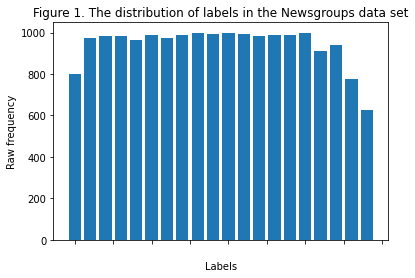

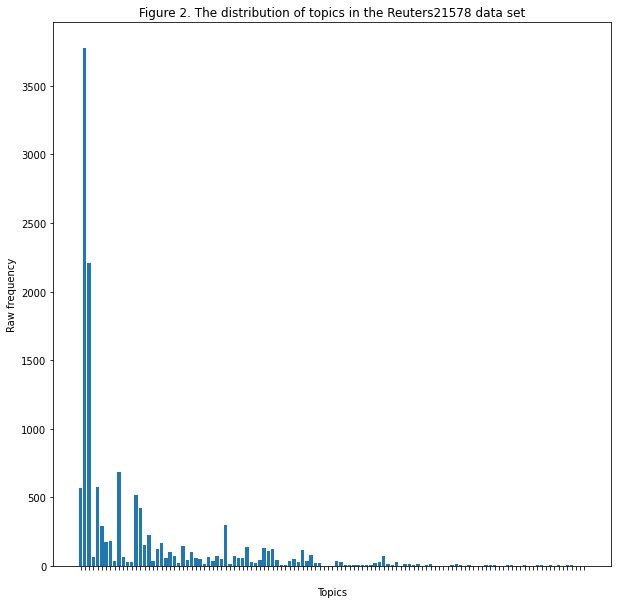

In [ ]:
import matplotlib.pyplot as plt

newsgroups_dict = {}
for group in newsgroups_dataset.target:
  if group not in newsgroups_dict.keys():
    newsgroups_dict[group] = 1
  else:
    newsgroups_dict[group] += 1
f1 = plt.figure(1)
f1 = plt.bar(*zip(*newsgroups_dict.items()))
f1 = plt.rcParams["figure.figsize"] = (10, 10)
f1 = plt.xticks(color='w')
f1 = plt.title("Figure 1. The distribution of labels in the Newsgroups data set")
f1 = plt.ylabel('Raw frequency')
f1 = plt.xlabel('Labels')

f2 = plt.figure(2)
f2 = plt.bar(*zip(*topics.items()))
f2 = plt.rcParams["figure.figsize"] = (10, 10)
f2 = plt.xticks(color='w')
f2 = plt.title("Figure 2. The distribution of topics in the Reuters21578 data set")
f2 = plt.ylabel('Raw frequency')
f2 = plt.xlabel('Topics')
plt.show()

# **FEATURE EXTRACTION**

I chose to use tf-idf vector representation in the classification pipeline because they, unlike binary Bag-of-Words vectors. The tf-idf vector represenatations are weighted; hence, the Euclidean distance will depend on not only presence but also salience of terms.

In addition to the defaul smoothing, I added two features to the vector representations:

1.   stop_words
2.   ngram_range

I excluded English stop words  from the vector representations since they add little to none value for the present task of classification. Lastly, I experimented with a variety of n-gram ranges; however, the result remained nearly identical, only being slightly better with the range of 1-3.

In [ ]:
############################ NEWSGROUPS ########################################
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(newsgroups_dataset.data, newsgroups_dataset.target, test_size=0.2)

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
label_binarizer = MultiLabelBinarizer()

X_train_news = vectorizer.fit_transform(X_train_news)
X_test_news = vectorizer.transform(X_test_news)

X_news_vectorized = vectorizer.fit_transform(newsgroups_dataset.data) # used for parameter search using cross validation
y_news = newsgroups_dataset.target # used for parameter search using cross validation

############################## REUTERS #########################################
X_train_reuters, X_test_reuters, y_train_reuters, y_test_reuters = train_test_split(X, y, test_size=0.15)

X_train_reuters = vectorizer.fit_transform(X_train_reuters)
X_test_reuters = vectorizer.transform(X_test_reuters)
y_train_reuters = label_binarizer.fit_transform(y_train_reuters)
y_test_reuters = label_binarizer.transform(y_test_reuters)

X_reuters_vectorized = vectorizer.fit_transform(X) # used for parameter search using cross validation
y_reuters_binarized = label_binarizer.transform(y) # used for parameter search using cross validation

# **MODEL CHOICE AND HYPERPARAMETER SEARCH**

**Non-probabilistic**. 



1. K-Nearest Neighbour

The model classifies documents by considering the labels of *K* closest data points in terms of Euclinean distance.

The inductive bias of the model lies solely in the fact that prediction is done with reference to the surounding data points and their Euclidean distance. Hence, the model leaves no space for outliers. Furthermore, since no weighting is done in this implementation, all features are considered equal, or, in other words, equally likely. The choice of k-parameter is therefore arguably the only means of controlling the generalisibility of the model.

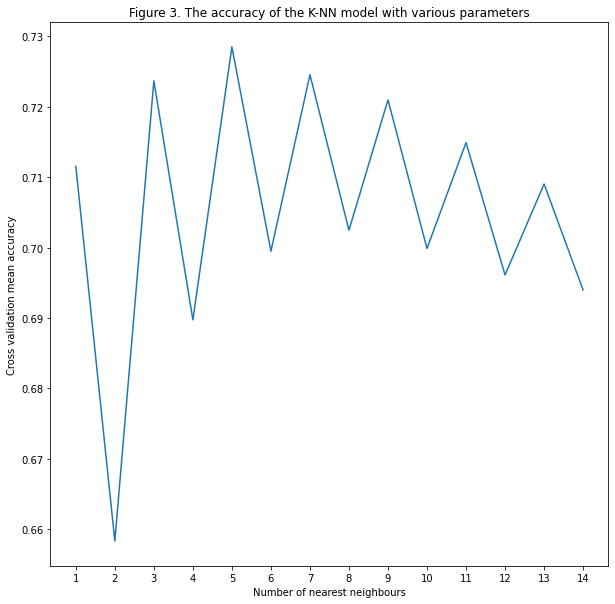

In [ ]:
################################# REUTERS ###################################### TRIGRAMS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsClassifier()

nearest_neighbours = list(range(1, 15))
param_grid = {'n_neighbors' : nearest_neighbours}
grid_search = GridSearchCV(knn_model, param_grid=param_grid)
reuters_knn_result = grid_search.fit(X_reuters_vectorized, y_reuters_binarized)

f3 = plt.plot(nearest_neighbours, grid_search.cv_results_['mean_test_score'])
f3 = plt.xticks(np.arange(min(nearest_neighbours), max(nearest_neighbours)+1, 1.0))
f3 = plt.title("Figure 3. Performance of the K-NN model on the Reuters21578 dataset")
f3 = plt.ylabel('Cross validation mean accuracy')
f3 = plt.xlabel('Number of nearest neighbours')

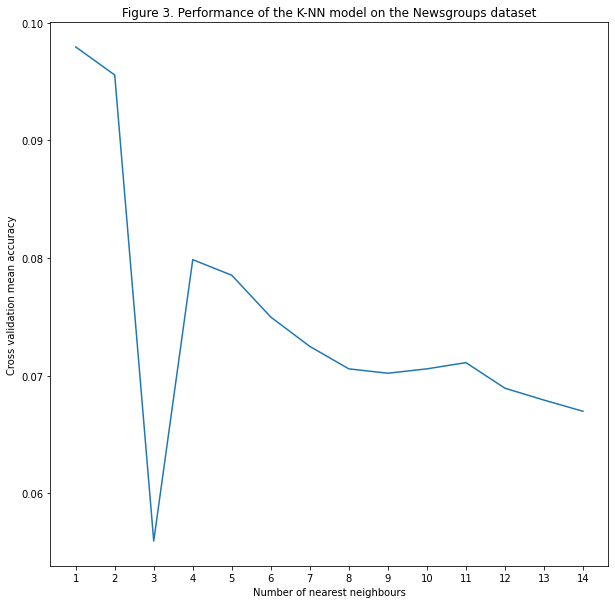

In [ ]:
############################### NEWSGROUPS #####################################
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsClassifier()
nearest_neighbours = list(range(1, 15))
param_grid = {'n_neighbors' : nearest_neighbours}
grid_search = GridSearchCV(knn_model, param_grid=param_grid)
news_knn_result = grid_search.fit(X_news_vectorized, y_news)

f4 = plt.plot(nearest_neighbours, grid_search.cv_results_['mean_test_score'])
f4 = plt.xticks(np.arange(min(nearest_neighbours), max(nearest_neighbours)+1, 1.0))
f4 = plt.title("Figure 4. Performance of the K-NN model on the Newsgroups dataset")
f4 = plt.ylabel('Cross validation mean accuracy')
f4 = plt.xlabel('Number of nearest neighbours')

The results of K-NN classifier on the Newsgroups dataset were horrible regardless of the parameters. The option that actually worked was including the metadata, namely headers, footers, and quotes:

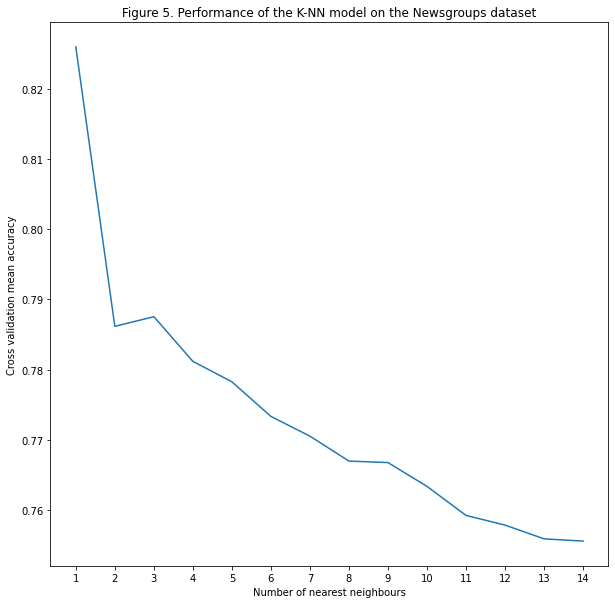

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

'Re-importing and vectorizing the data without dropping the metadata (headers, footers, quotes)'

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
newsgroups_dataset = fetch_20newsgroups(subset='all') # used for parameter search using cross validation 
X_news_vectorized = vectorizer.fit_transform(newsgroups_dataset.data) # used for parameter search using cross validation
y_news = newsgroups_dataset.target # used for parameter search using cross validation

knn_model = KNeighborsClassifier()
nearest_neighbours = list(range(1, 15))
param_grid = {'n_neighbors' : nearest_neighbours}
grid_search = GridSearchCV(knn_model, param_grid=param_grid)
news_knn_result = grid_search.fit(X_news_vectorized, y_news)

f5 = plt.plot(nearest_neighbours, grid_search.cv_results_['mean_test_score'])
f5 = plt.xticks(np.arange(min(nearest_neighbours), max(nearest_neighbours)+1, 1.0))
f5 = plt.title("Figure 5. Performance of the K-NN model on the Newsgroups dataset")
f5 = plt.ylabel('Cross validation mean accuracy')
f5 = plt.xlabel('Number of nearest neighbours')

2. Random Forest

In [ ]:
############################### NEWSGROUPS #####################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


random_forest = RandomForestClassifier()
param_grid = {'max_depth' : [5, 10, 15, 20], 'n_estimators': [70, 80, 90, 100, 110]}
grid_search = GridSearchCV(random_forest, param_grid=param_grid)
best_parameter = grid_search.fit(X_news_vectorized, y_news)

**Multinomial Naive Bayes** - probabilistic.


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 19 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 19 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 19 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training 

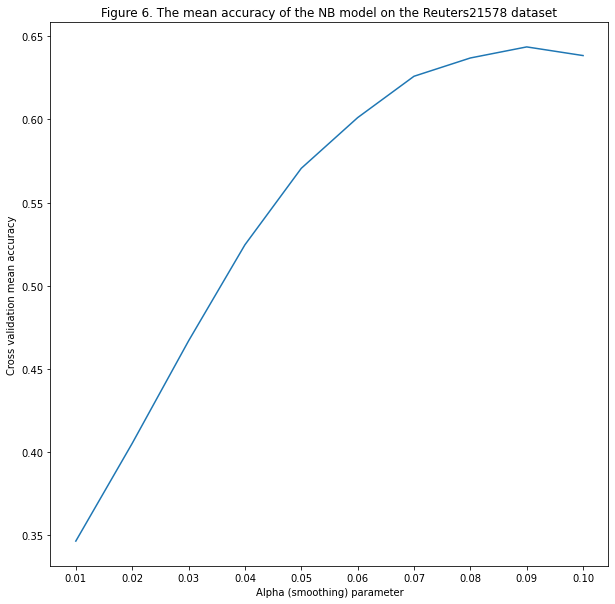

In [ ]:
################################# REUTERS ######################################
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

model = OneVsRestClassifier(MultinomialNB())
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07
          , 0.08, 0.09, 0.1]
param_grid = {'estimator__alpha' : alphas}
grid_search = GridSearchCV(model, param_grid=param_grid)
reuters_nb_result = grid_search.fit(X_reuters_vectorized, y_reuters_binarized)

f6 = plt.plot(alphas, grid_search.cv_results_['mean_test_score'])
f6 = plt.xticks(np.arange(min(alphas), 0.11, 0.01))
f6 = plt.title("Figure 6. The mean accuracy of the NB model on the Reuters21578 dataset")
f6 = plt.ylabel('Cross validation mean accuracy')
f6 = plt.xlabel('Alpha (smoothing) parameter')

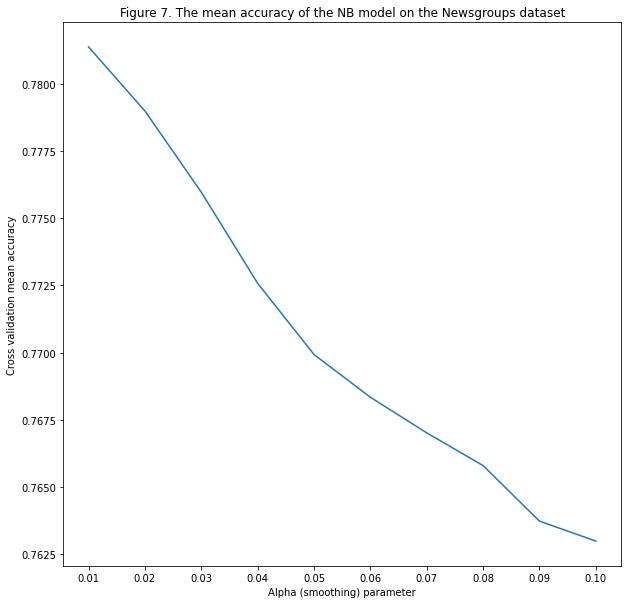

In [ ]:
############################### NEWSGROUPS #####################################
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

multinomial_nb = MultinomialNB()
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07
          , 0.08, 0.09, 0.1]
param_grid = {'alpha' : alphas}
grid_search = GridSearchCV(multinomial_nb, param_grid=param_grid)
news_nb_result = grid_search.fit(X_news_vectorized, y_news)

f7 = plt.plot(alphas, grid_search.cv_results_['mean_test_score'])
f7 = plt.xticks(np.arange(min(alphas), 0.11, 0.01))
f7 = plt.title("Figure 7. The mean accuracy of the NB model on the Newsgroups dataset")
f7 = plt.ylabel('Cross validation mean accuracy')
f7 = plt.xlabel('Alpha (smoothing) parameter')

# **EVALUATION OF THE MODELS**

Having found what seems to be the most optimal parameters, the models will further be compared in terms of their performance on the two datasets. 

**NON-PROBABILISTIC**
1. K_NN

In [ ]:
################################# REUTERS ######################################
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_reuters, y_train_reuters)

print(classification_report(y_test_reuters, knn_model.predict(X_test_reuters)))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       457
           1       0.80      0.53      0.64        15
           2       0.00      0.00      0.00         1
           3       1.00      0.22      0.36         9
           4       0.56      0.53      0.55        17
           5       0.00      0.00      0.00         0
           6       0.83      0.26      0.40        19
           7       0.00      0.00      0.00         0
           8       0.85      0.65      0.73        17
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.95      0.82      0.88        22
          12       1.00      0.56      0.71        18
          13       0.00      0.00      0.00         0
          14       0.84      0.54      0.66        48
          15       0.00      0.00      0.00         0
          16       1.00      0.12      0.22         8
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
############################### NEWSGROUPS ##################################### # WITH METADATA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))

X_train_news = vectorizer.fit_transform(newsgroups_train.data)
X_test_news = vectorizer.transform(newsgroups_test.data)
y_train_news = newsgroups_train.target
y_test_news = newsgroups_test.target

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train_news, y_train_news)

print(classification_report(y_test_news, knn_model.predict(X_test_news))) 

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       319
           1       0.47      0.49      0.48       389
           2       0.45      0.44      0.45       394
           3       0.48      0.54      0.51       392
           4       0.53      0.53      0.53       385
           5       0.60      0.55      0.57       395
           6       0.51      0.46      0.49       390
           7       0.69      0.62      0.66       396
           8       0.77      0.85      0.81       398
           9       0.64      0.68      0.66       397
          10       0.72      0.79      0.75       399
          11       0.76      0.79      0.77       396
          12       0.61      0.60      0.60       393
          13       0.62      0.55      0.58       396
          14       0.67      0.77      0.71       394
          15       0.79      0.79      0.79       398
          16       0.70      0.64      0.67       364
          17       0.84    

In [ ]:
############################### NEWSGROUPS ##################################### # WITHOUT METADATA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))

X_train_news = vectorizer.fit_transform(newsgroups_train.data)
X_test_news = vectorizer.transform(newsgroups_test.data)
y_train_news = newsgroups_train.target
y_test_news = newsgroups_test.target

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train_news, y_train_news)

print(classification_report(y_test_news, knn_model.predict(X_test_news))) 

              precision    recall  f1-score   support

           0       0.95      0.06      0.11       319
           1       0.85      0.03      0.05       389
           2       0.75      0.02      0.03       394
           3       0.93      0.06      0.12       392
           4       0.05      1.00      0.10       385
           5       1.00      0.04      0.07       395
           6       1.00      0.09      0.17       390
           7       0.62      0.01      0.02       396
           8       0.97      0.08      0.15       398
           9       0.92      0.03      0.05       397
          10       0.96      0.06      0.11       399
          11       0.61      0.04      0.07       396
          12       0.85      0.03      0.05       393
          13       1.00      0.02      0.04       396
          14       0.86      0.06      0.12       394
          15       0.80      0.02      0.04       398
          16       0.62      0.01      0.03       364
          17       1.00    

2. RANDOM FOREST

In [ ]:
############################ RANDOM FOREST #####################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

random_forest = RandomForestClassifier(max_depth=55, n_estimators= 121)
random_forest.fit(X_train_news, y_train_news)

print(classification_report(y_test_news, random_forest.predict(X_test_news)))

              precision    recall  f1-score   support

           0       0.74      0.60      0.66       319
           1       0.62      0.67      0.64       389
           2       0.67      0.72      0.69       394
           3       0.60      0.70      0.65       392
           4       0.75      0.78      0.76       385
           5       0.74      0.73      0.74       395
           6       0.63      0.85      0.72       390
           7       0.85      0.83      0.84       396
           8       0.88      0.91      0.90       398
           9       0.89      0.84      0.87       397
          10       0.83      0.95      0.89       399
          11       0.82      0.91      0.86       396
          12       0.60      0.45      0.51       393
          13       0.85      0.61      0.71       396
          14       0.84      0.89      0.86       394
          15       0.69      0.93      0.79       398
          16       0.72      0.87      0.79       364
          17       0.96    

**PROBABILISTIC**


MULTINOMIAL NAIVE BAYES

In [ ]:
################################# REUTERS ######################################
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(MultinomialNB(alpha=0.09))
model.fit(X_train_reuters, y_train_reuters)

print(classification_report(y_test_reuters, model.predict(X_test_reuters)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       315
           1       1.00      0.08      0.15        12
           2       0.00      0.00      0.00         1
           3       1.00      0.08      0.15        12
           4       1.00      0.07      0.13        14
           5       0.00      0.00      0.00         0
           6       1.00      0.09      0.17        11
           7       0.00      0.00      0.00         1
           8       1.00      0.07      0.13        14
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      0.09      0.16        23
          12       1.00      0.57      0.73         7
          13       0.00      0.00      0.00         1
          14       0.80      0.10      0.17        42
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00        11
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
############################### NEWSGROUPS #####################################
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

model = MultinomialNB(alpha=0.01)
model.fit(X_train_news, y_train_news)

print(classification_report(y_test_news, model.predict(X_test_news)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       319
           1       0.69      0.68      0.68       389
           2       0.70      0.64      0.66       394
           3       0.63      0.70      0.67       392
           4       0.79      0.76      0.77       385
           5       0.79      0.77      0.78       395
           6       0.78      0.78      0.78       390
           7       0.83      0.86      0.84       396
           8       0.90      0.94      0.92       398
           9       0.89      0.89      0.89       397
          10       0.89      0.94      0.92       399
          11       0.84      0.91      0.87       396
          12       0.76      0.69      0.73       393
          13       0.84      0.75      0.79       396
          14       0.82      0.88      0.84       394
          15       0.85      0.94      0.89       398
          16       0.78      0.89      0.83       364
          17       0.94    